In [120]:
import cv2

import os

import caffe

import numpy as np

import matplotlib.pyplot as plt

import sys

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (5, 5)

plt.rcParams['image.interpolation'] = 'nearest'

plt.rcParams['image.cmap'] = 'gray'

In [3]:
caffe_root = '../caffe/'

if os.path.isfile(caffe_root + 'model/blvc_reference_caffenet/blvc_reference_caffenet.caffemodel'):
    print 'CaffeNet found'
else:
    print "Downloading pre-trained CaffeNet model..."
    !../caffe/scripts/download_model_binary.py ../caffe/models/bvlc_reference_caffenet

Model already exists.


In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'

model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST)

In [5]:
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')

mu = mu.mean(1).mean(1)

print 'mean-subtracted values:', zip('BGR', mu)

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [6]:
transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})

transformer.set_transpose('data',(2,0,1)) #change channel w, h, and color order

transformer.set_mean('data', mu)

transformer.set_raw_scale('data', 255)

transformer.set_channel_swap('data', (2,1,0)) #change RGB to RGB

In [7]:
net.blobs['data'].reshape(50, 3, 227, 227)

In [8]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')

In [129]:
cap = cv2.VideoCapture(0)

_,image = cap.read()

cap.release()

image = image[:,:,::-1]

In [131]:
transformed_image = transformer.preprocess('data', image)

In [132]:
net.blobs['data'].data[...] = transformed_image

In [133]:
output = net.forward()

In [134]:
output_prob = output['prob'][0]

In [135]:
label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'

In [136]:
labels = np.loadtxt(label_file, str, delimiter='\t')

In [137]:
print 'output label:', labels[output_prob.argmax()]

output label: n09229709 bubble


In [138]:
top_inds = output_prob.argsort()[::-1][:5]

In [139]:
print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.10436243, 'n09229709 bubble'),
 (0.027485378, 'n03595614 jersey, T-shirt, tee shirt'),
 (0.022944719, 'n06359193 web site, website, internet site, site'),
 (0.020648997, 'n03617480 kimono'),
 (0.018608723, 'n03476684 hair slide')]

In [18]:
%timeit net.forward()

1 loop, best of 3: 6.87 s per loop


#### Examing intermediate oputput
- why blob shape is 96, 55, 55 in layer conv1 -- prototxt group is 2

In [140]:
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [141]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [142]:
filters = net.params['conv1'][0].data

In [143]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

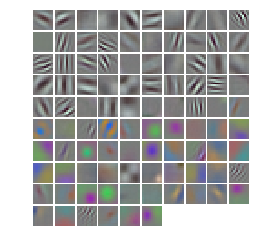

In [144]:
vis_square(filters.transpose(0,2,3,1))

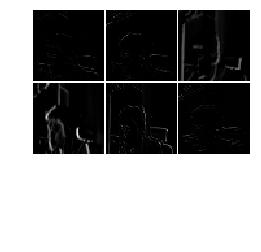

In [153]:
feat = net.blobs['conv1'].data[0][:6]
vis_square(feat)

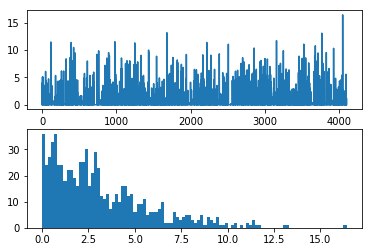

In [158]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

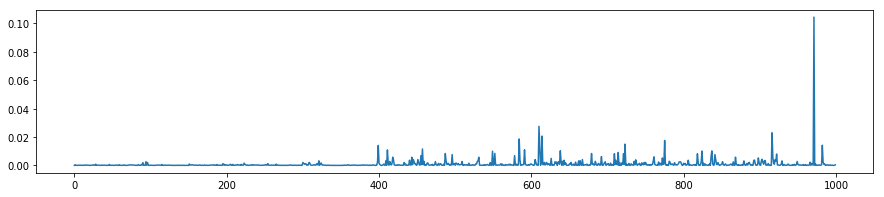

In [159]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)